## Project Initialization

### Google drive

In [ ]:
try:
    # Check if running in Google Colab
    if 'google.colab' in str(get_ipython()):
        from google.colab import drive
        drive.mount('/content/drive')  # Mount Google Drive
        %cd /content/drive/MyDrive/Colab Notebooks/project_a/src
        !pip install thop
    else:
        print("Not running in Google Colab. Google Drive will not be mounted.")
except NameError:
    print("Not running in an IPython environment.")

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torchvision.utils import save_image
from thop import profile
import sys
from PIL import Image


figures_dir = '../report/figures/'
output_dir = '../output/'


print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
    properties = torch.cuda.get_device_properties(0)
    compute_capability = f"{properties.major}.{properties.minor}"
    total_memory = properties.total_memory / 1024**3

    print(f"CUDA Device: {device_name}")
    print(f"CUDA Compute Capability: {compute_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    device = torch.device("cpu")
    print("GPU is not available")


### MHISTDataet.py

In [3]:
from pathlib import Path
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class MHISTDataset(Dataset):
    def __init__(self, images_dir, annotations_file, train=True, transform=None):
        """
        Args:
            images_dir (str): Directory containing all images.
            annotations_file (str): Path to the CSV file with annotations.
            train (bool): Flag indicating whether to load the training or test partition.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images_dir = Path(images_dir)
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform

        # Filter annotations based on the partition
        partition = 'train' if train else 'test'
        self.annotations = self.annotations[self.annotations['Partition'] == partition]

        # Map folder names to class labels
        self.label_map = {"HP": 0, "SSA": 1}

        # Gather image file paths and their corresponding labels
        self.image_paths = self.annotations['Image Name'].apply(lambda x: self.images_dir / x).tolist()
        self.labels = self.annotations['Majority Vote Label'].map(self.label_map).tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the image path and corresponding label
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        label = self.labels[idx]
        # Map label to class name, if 0 then HP, if 1 then SSA
        name = "HP" if label == 0 else "SSA"

        if self.transform:
            image = self.transform(image)

        return image, label

### Networks.py

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Acknowledgement to
# https://github.com/kuangliu/pytorch-cifar,
# https://github.com/BIGBALLON/CIFAR-ZOO,

"""
https://github.com/DataDistillation/attention_matching/

A. Sajedi, S. Khaki, E. Amjadian, L. Z. Liu, Y. A. Lawryshyn, and K. N. Plataniotis,
DataDAM: Efficient Dataset Distillation with Attention Matching. 2023. [Online].
Available: https://arxiv.org/abs/2310.00093
"""

''' Swish activation '''
class Swish(nn.Module): # Swish(x) = x∗σ(x)
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.sigmoid(input)


''' MLP '''
class MLP(nn.Module):
    def __init__(self, channel, num_classes):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1 if channel==1 else 32*32*3, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)
        return out



''' ConvNet '''
class ConvNet(nn.Module):
    def __init__(self, channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size = (32,32)):
        super(ConvNet, self).__init__()

        self.features, shape_feat = self._make_layers(channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size)
        num_feat = shape_feat[0]*shape_feat[1]*shape_feat[2]
        self.classifier = nn.Linear(num_feat, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        return out

    def _get_activation(self, net_act):
        if net_act == 'sigmoid':
            return nn.Sigmoid()
        elif net_act == 'relu':
            return nn.ReLU(inplace=True)
        elif net_act == 'leakyrelu':
            return nn.LeakyReLU(negative_slope=0.01)
        elif net_act == 'swish':
            return Swish()
        else:
            exit('unknown activation function: %s'%net_act)

    def _get_pooling(self, net_pooling):
        if net_pooling == 'maxpooling':
            return nn.MaxPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'avgpooling':
            return nn.AvgPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'none':
            return None
        else:
            exit('unknown net_pooling: %s'%net_pooling)

    def _get_normlayer(self, net_norm, shape_feat):
        # shape_feat = (c*h*w)
        if net_norm == 'batchnorm':
            return nn.BatchNorm2d(shape_feat[0], affine=True)
        elif net_norm == 'layernorm':
            return nn.LayerNorm(shape_feat, elementwise_affine=True)
        elif net_norm == 'instancenorm':
            return nn.GroupNorm(shape_feat[0], shape_feat[0], affine=True)
        elif net_norm == 'groupnorm':
            return nn.GroupNorm(4, shape_feat[0], affine=True)
        elif net_norm == 'none':
            return None
        else:
            exit('unknown net_norm: %s'%net_norm)

    def _make_layers(self, channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size):
        layers = []
        in_channels = channel
        if im_size[0] == 28:
            im_size = (32, 32)
        shape_feat = [in_channels, im_size[0], im_size[1]]
        for d in range(net_depth):
            layers += [nn.Conv2d(in_channels, net_width, kernel_size=3, padding=3 if channel == 1 and d == 0 else 1)]
            shape_feat[0] = net_width
            if net_norm != 'none':
                layers += [self._get_normlayer(net_norm, shape_feat)]
            layers += [self._get_activation(net_act)]
            in_channels = net_width
            if net_pooling != 'none':
                layers += [self._get_pooling(net_pooling)]
                shape_feat[1] //= 2
                shape_feat[2] //= 2

        return nn.Sequential(*layers), shape_feat



''' LeNet '''
class LeNet(nn.Module):
    def __init__(self, channel, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 6, kernel_size=5, padding=2 if channel==1 else 0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x



''' AlexNet '''
class AlexNet(nn.Module):
    def __init__(self, channel, num_classes, im_size):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 128, kernel_size=5, stride=1, padding=4 if channel==1 else 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        #self.fc = nn.Linear(192 * 4 * 4, num_classes)
        # Calculate the flattened size for the fully connected layer
        conv_output_size = self._get_conv_output_size(im_size, channel)
        
        # Fully connected layer
        self.fc = nn.Linear(conv_output_size, num_classes)  # Fully connected layer
    
    def _get_conv_output_size(self, im_size, channel):
        # Helper function to calculate the output size of the convolutional layers
        x = torch.rand(1, channel, im_size[0], im_size[1])  # Random input tensor with the given image size and channel
        x = self.features(x)
        return x.view(1, -1).size(1)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


''' AlexNetBN '''
class AlexNetBN(nn.Module):
    def __init__(self, channel, num_classes, im_size):
        super(AlexNetBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 128, kernel_size=5, stride=1, padding=4 if channel==1 else 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(192 * 4 * 4, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


''' VGG '''
cfg_vgg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
class VGG(nn.Module):
    def __init__(self, vgg_name, channel, num_classes, norm='instancenorm'):
        super(VGG, self).__init__()
        self.channel = channel
        self.features = self._make_layers(cfg_vgg[vgg_name], norm)
        self.classifier = nn.Linear(512 if vgg_name != 'VGGS' else 128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

    def _make_layers(self, cfg, norm):
        layers = []
        in_channels = self.channel
        for ic, x in enumerate(cfg):
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=3 if self.channel==1 and ic==0 else 1),
                           nn.GroupNorm(x, x, affine=True) if norm=='instancenorm' else nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11(channel, num_classes):
    return VGG('VGG11', channel, num_classes)
def VGG11BN(channel, num_classes):
    return VGG('VGG11', channel, num_classes, norm='batchnorm')
def VGG13(channel, num_classes):
    return VGG('VGG13', channel, num_classes)
def VGG16(channel, num_classes):
    return VGG('VGG16', channel, num_classes)
def VGG19(channel, num_classes):
    return VGG('VGG19', channel, num_classes)


''' ResNet_AP '''
# The conv(stride=2) is replaced by conv(stride=1) + avgpool(kernel_size=2, stride=2)

class BasicBlock_AP(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock_AP, self).__init__()
        self.norm = norm
        self.stride = stride
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # modification
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=1, bias=False),
                nn.AvgPool2d(kernel_size=2, stride=2), # modification
                nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.stride != 1: # modification
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck_AP(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(Bottleneck_AP, self).__init__()
        self.norm = norm
        self.stride = stride
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # modification
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=1, bias=False),
                nn.AvgPool2d(kernel_size=2, stride=2),  # modification
                nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.stride != 1: # modification
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_AP(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet_AP, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512 * block.expansion * 3 * 3 if channel==1 else 512 * block.expansion * 4 * 4, num_classes)  # modification

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, kernel_size=1, stride=1) # modification
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, kernel_size=1, stride=1) # modification
        out = out.view(out.size(0), -1)
        return out

def ResNet18BN_AP(channel, num_classes):
    return ResNet_AP(BasicBlock_AP, [2,2,2,2], channel=channel, num_classes=num_classes, norm='batchnorm')

def ResNet18_AP(channel, num_classes):
    return ResNet_AP(BasicBlock_AP, [2,2,2,2], channel=channel, num_classes=num_classes)


''' ResNet '''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(Bottleneck, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out


def ResNet18BN(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes, norm='batchnorm')

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes)

def ResNet34(channel, num_classes):
    return ResNet(BasicBlock, [3,4,6,3], channel=channel, num_classes=num_classes)

def ResNet50(channel, num_classes):
    return ResNet(Bottleneck, [3,4,6,3], channel=channel, num_classes=num_classes)

def ResNet101(channel, num_classes):
    return ResNet(Bottleneck, [3,4,23,3], channel=channel, num_classes=num_classes)

def ResNet152(channel, num_classes):
    return ResNet(Bottleneck, [3,8,36,3], channel=channel, num_classes=num_classes)

### Utils.py

In [5]:
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from scipy.ndimage import rotate as scipyrotate
import sys
#from networks import MLP, ConvNet, LeNet, AlexNet, AlexNetBN, VGG11, VGG11BN, ResNet18, ResNet18BN_AP, ResNet18BN
#import MHISTDataset

"""
https://github.com/DataDistillation/DataDAM/

A. Sajedi, S. Khaki, E. Amjadian, L. Z. Liu, Y. A. Lawryshyn, and K. N. Plataniotis,
DataDAM: Efficient Dataset Distillation with Attention Matching. 2023. [Online].
Available: https://arxiv.org/abs/2310.00093
"""
def get_attention(feature_set, param=0, exp=4, norm='l2'):
    if param==0:
        attention_map = torch.sum(torch.abs(feature_set), dim=1)

    elif param ==1:
        attention_map =  torch.sum(torch.abs(feature_set)**exp, dim=1)

    elif param == 2:
        attention_map =  torch.max(torch.abs(feature_set)**exp, dim=1)

    if norm == 'l2':
        # Dimension: [B x (H*W)] -- Vectorized
        vectorized_attention_map =  attention_map.view(feature_set.size(0), -1)
        normalized_attention_maps = F.normalize(vectorized_attention_map, p=2.0)

    elif norm == 'fro':
        # Dimension: [B x H x W] -- Un-Vectorized
        un_vectorized_attention_map =  attention_map
        # Dimension: [B]
        fro_norm = torch.sum(torch.sum(torch.abs(attention_map)**2, dim=1), dim=1)
        # Dimension: [B x H x W] -- Un-Vectorized)
        normalized_attention_maps = un_vectorized_attention_map / fro_norm.unsqueeze(dim=-1).unsqueeze(dim=-1)
    elif norm == 'l1':
        # Dimension: [B x (H*W)] -- Vectorized
        vectorized_attention_map =  attention_map.view(feature_set.size(0), -1)
        normalized_attention_maps = F.normalize(vectorized_attention_map, p=1.0)

    elif norm =='none':
        normalized_attention_maps = attention_map

    elif norm == 'none-vectorized':
        normalized_attention_maps =  attention_map.view(feature_set.size(0), -1)

    return normalized_attention_maps

def get_dataset(dataset, data_path):
    if dataset == 'MNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'FashionMNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.2861]
        std = [0.3530]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'SVHN':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4377, 0.4438, 0.4728]
        std = [0.1980, 0.2010, 0.1970]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.SVHN(data_path, split='train', download=True, transform=transform)  # no augmentation
        dst_test = datasets.SVHN(data_path, split='test', download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'CIFAR10':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'CIFAR100':
        channel = 3
        im_size = (32, 32)
        num_classes = 100
        mean = [0.5071, 0.4866, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR100(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR100(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'TinyImageNet':
        channel = 3
        im_size = (64, 64)
        num_classes = 200
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        data = torch.load(os.path.join(data_path, 'tinyimagenet.pt'), map_location='cpu')

        class_names = data['classes']

        images_train = data['images_train']
        labels_train = data['labels_train']
        images_train = images_train.detach().float() / 255.0
        labels_train = labels_train.detach()
        for c in range(channel):
            images_train[:,c] = (images_train[:,c] - mean[c])/std[c]
        dst_train = TensorDataset(images_train, labels_train)  # no augmentation

        images_val = data['images_val']
        labels_val = data['labels_val']
        images_val = images_val.detach().float() / 255.0
        labels_val = labels_val.detach()

        for c in range(channel):
            images_val[:, c] = (images_val[:, c] - mean[c]) / std[c]

        dst_test = TensorDataset(images_val, labels_val)  # no augmentation

    elif dataset == 'MHIST':
        channel = 3
        im_size = (224, 224)
        num_classes = 2
        class_names = ['HP', 'SSA']
        images_dir = '../mhist_dataset/images/'
        annotation_file = '../mhist_dataset/annotations.csv'
        to_tensor = transforms.ToTensor()

        dst_train = MHISTDataset(images_dir, annotation_file, train=True, transform=to_tensor)
        dst_test = MHISTDataset(images_dir, annotation_file, train=False, transform=to_tensor)

        # calculate mean and std
        mean = [0.5, 0.5, 0.5]  # Adjust these values based on dataset statistics
        std = [0.1, 0.1, 0.1]  # Adjust these values based on dataset statistics

    else:
        exit('unknown dataset: %s'%dataset)


    testloader = torch.utils.data.DataLoader(dst_test, batch_size=64, shuffle=False, num_workers=0)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True, num_workers=0)
    return channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader, trainloader



class TensorDataset(Dataset):
    def __init__(self, images, labels): # images: n x c x h x w tensor
        self.images = images.detach().float()
        self.labels = labels.detach()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]



def get_default_convnet_setting():
    net_width, net_depth, net_act, net_norm, net_pooling = 128, 3, 'relu', 'instancenorm', 'avgpooling'
    return net_width, net_depth, net_act, net_norm, net_pooling



def get_network(model, channel, num_classes, im_size=(32, 32)):
    torch.random.manual_seed(int(time.time() * 1000) % 100000)
    net_width, net_depth, net_act, net_norm, net_pooling = get_default_convnet_setting()

    if model == 'MLP':
        net = MLP(channel=channel, num_classes=num_classes)
    elif model == 'ConvNet':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'LeNet':
        net = LeNet(channel=channel, num_classes=num_classes)
    elif model == 'AlexNet':
        net = AlexNet(channel=channel, num_classes=num_classes, im_size=im_size)
    elif model == 'AlexNetBN':
        net = AlexNetBN(channel=channel, num_classes=num_classes)
    elif model == 'VGG11':
        net = VGG11( channel=channel, num_classes=num_classes)
    elif model == 'VGG11BN':
        net = VGG11BN(channel=channel, num_classes=num_classes)
    elif model == 'ResNet18':
        net = ResNet18(channel=channel, num_classes=num_classes)
    elif model == 'ResNet18BN_AP':
        net = ResNet18BN_AP(channel=channel, num_classes=num_classes)
    elif model == 'ResNet18BN':
        net = ResNet18BN(channel=channel, num_classes=num_classes)

    elif model == 'ConvNetD1':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=1, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD2':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=2, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD3':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD4':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=4, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD7':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=7, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW32':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=32, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW64':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=64, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW128':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=128, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW256':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=256, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetAS':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='sigmoid', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetAR':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='relu', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetAL':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='leakyrelu', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetASwish':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='swish', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetASwishBN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='swish', net_norm='batchnorm', net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetNN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='none', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetBN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='batchnorm', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetLN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='layernorm', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetIN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='instancenorm', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetGN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='groupnorm', net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetNP':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling='none', im_size=im_size)
    elif model == 'ConvNetMP':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling='maxpooling', im_size=im_size)
    elif model == 'ConvNetAP':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling='avgpooling', im_size=im_size)

    else:
        net = None
        exit('unknown model: %s'%model)

    gpu_num = torch.cuda.device_count()
    if gpu_num>0:
        device = 'cuda'
        if gpu_num>1:
            net = nn.DataParallel(net)
    else:
        device = 'cpu'
    net = net.to(device)

    return net



def get_time():
    return str(time.strftime("[%Y-%m-%d %H:%M:%S]", time.localtime()))



def distance_wb(gwr, gws):
    shape = gwr.shape
    if len(shape) == 4: # conv, out*in*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2] * shape[3])
        gws = gws.reshape(shape[0], shape[1] * shape[2] * shape[3])
    elif len(shape) == 3:  # layernorm, C*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2])
        gws = gws.reshape(shape[0], shape[1] * shape[2])
    elif len(shape) == 2: # linear, out*in
        tmp = 'do nothing'
    elif len(shape) == 1: # batchnorm/instancenorm, C; groupnorm x, bias
        gwr = gwr.reshape(1, shape[0])
        gws = gws.reshape(1, shape[0])
        return torch.tensor(0, dtype=torch.float, device=gwr.device)

    dis_weight = torch.sum(1 - torch.sum(gwr * gws, dim=-1) / (torch.norm(gwr, dim=-1) * torch.norm(gws, dim=-1) + 0.000001))
    dis = dis_weight
    return dis



def match_loss(gw_syn, gw_real, args):
    dis = torch.tensor(0.0).to(args.device)

    if args.dis_metric == 'ours':
        for ig in range(len(gw_real)):
            gwr = gw_real[ig]
            gws = gw_syn[ig]
            dis += distance_wb(gwr, gws)

    elif args.dis_metric == 'mse':
        gw_real_vec = []
        gw_syn_vec = []
        for ig in range(len(gw_real)):
            gw_real_vec.append(gw_real[ig].reshape((-1)))
            gw_syn_vec.append(gw_syn[ig].reshape((-1)))
        gw_real_vec = torch.cat(gw_real_vec, dim=0)
        gw_syn_vec = torch.cat(gw_syn_vec, dim=0)
        dis = torch.sum((gw_syn_vec - gw_real_vec)**2)

    elif args.dis_metric == 'cos':
        gw_real_vec = []
        gw_syn_vec = []
        for ig in range(len(gw_real)):
            gw_real_vec.append(gw_real[ig].reshape((-1)))
            gw_syn_vec.append(gw_syn[ig].reshape((-1)))
        gw_real_vec = torch.cat(gw_real_vec, dim=0)
        gw_syn_vec = torch.cat(gw_syn_vec, dim=0)
        dis = 1 - torch.sum(gw_real_vec * gw_syn_vec, dim=-1) / (torch.norm(gw_real_vec, dim=-1) * torch.norm(gw_syn_vec, dim=-1) + 0.000001)

    else:
        exit('unknown distance function: %s'%args.dis_metric)

    return dis



def get_loops(ipc):
    # Get the two hyper-parameters of outer-loop and inner-loop.
    # The following values are empirically good.
    if ipc == 1:
        outer_loop, inner_loop = 1, 1
    elif ipc == 10:
        outer_loop, inner_loop = 10, 50
    elif ipc == 20:
        outer_loop, inner_loop = 20, 25
    elif ipc == 30:
        outer_loop, inner_loop = 30, 20
    elif ipc == 40:
        outer_loop, inner_loop = 40, 15
    elif ipc == 50:
        outer_loop, inner_loop = 50, 10
    else:
        outer_loop, inner_loop = 0, 0
        exit('loop hyper-parameters are not defined for %d ipc'%ipc)
    return outer_loop, inner_loop



def epoch(mode, dataloader, net, optimizer, criterion, args, aug):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(args.device)
    criterion = criterion.to(args.device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):
        img = datum[0].float().to(args.device)
        if aug:
            if args.dsa:
                img = DiffAugment(img, args.dsa_strategy, param=args.dsa_param)
            else:
                pass
                #img = augment(img, args.dc_aug_param, device=args.device)
        lab = datum[1].long().to(args.device)
        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg



def evaluate_synset(it_eval, net, images_train, labels_train, testloader, args):
    net = net.to(args.device)
    images_train = images_train.to(args.device)
    labels_train = labels_train.to(args.device)
    lr = float(args.lr_net)
    Epoch = int(args.epoch_eval_train)
    lr_schedule = [Epoch//2+1]
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss().to(args.device)

    dst_train = TensorDataset(images_train, labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=args.batch_train, shuffle=True, num_workers=0)

    start = time.time()
    for ep in range(Epoch+1):
        loss_train, acc_train = epoch('train', trainloader, net, optimizer, criterion, args, aug = True)
        if ep in lr_schedule:
            lr *= 0.1
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    time_train = time.time() - start
    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, args, aug = False)
    print('%s Evaluate_%02d: epoch = %04d train time = %d s train loss = %.6f train acc = %.4f, test acc = %.4f' % (get_time(), it_eval, Epoch, int(time_train), loss_train, acc_train, acc_test))

    return net, acc_train, acc_test



def augment(images, dc_aug_param, device):
    # This can be sped up in the future.

    if dc_aug_param != None and dc_aug_param['strategy'] != 'none':
        scale = dc_aug_param['scale']
        crop = dc_aug_param['crop']
        rotate = dc_aug_param['rotate']
        noise = dc_aug_param['noise']
        strategy = dc_aug_param['strategy']

        shape = images.shape
        mean = []
        for c in range(shape[1]):
            mean.append(float(torch.mean(images[:,c])))

        def cropfun(i):
            im_ = torch.zeros(shape[1],shape[2]+crop*2,shape[3]+crop*2, dtype=torch.float, device=device)
            for c in range(shape[1]):
                im_[c] = mean[c]
            im_[:, crop:crop+shape[2], crop:crop+shape[3]] = images[i]
            r, c = np.random.permutation(crop*2)[0], np.random.permutation(crop*2)[0]
            images[i] = im_[:, r:r+shape[2], c:c+shape[3]]

        def scalefun(i):
            h = int((np.random.uniform(1 - scale, 1 + scale)) * shape[2])
            w = int((np.random.uniform(1 - scale, 1 + scale)) * shape[2])
            tmp = F.interpolate(images[i:i + 1], [h, w], )[0]
            mhw = max(h, w, shape[2], shape[3])
            im_ = torch.zeros(shape[1], mhw, mhw, dtype=torch.float, device=device)
            r = int((mhw - h) / 2)
            c = int((mhw - w) / 2)
            im_[:, r:r + h, c:c + w] = tmp
            r = int((mhw - shape[2]) / 2)
            c = int((mhw - shape[3]) / 2)
            images[i] = im_[:, r:r + shape[2], c:c + shape[3]]

        def rotatefun(i):
            im_ = scipyrotate(images[i].cpu().data.numpy(), angle=np.random.randint(-rotate, rotate), axes=(-2, -1), cval=np.mean(mean))
            r = int((im_.shape[-2] - shape[-2]) / 2)
            c = int((im_.shape[-1] - shape[-1]) / 2)
            images[i] = torch.tensor(im_[:, r:r + shape[-2], c:c + shape[-1]], dtype=torch.float, device=device)

        def noisefun(i):
            images[i] = images[i] + noise * torch.randn(shape[1:], dtype=torch.float, device=device)


        augs = strategy.split('_')

        for i in range(shape[0]):
            choice = np.random.permutation(augs)[0] # randomly implement one augmentation
            if choice == 'crop':
                cropfun(i)
            elif choice == 'scale':
                scalefun(i)
            elif choice == 'rotate':
                rotatefun(i)
            elif choice == 'noise':
                noisefun(i)

    return images



def get_daparam(dataset, model, model_eval, ipc):
    # We find that augmentation doesn't always benefit the performance.
    # So we do augmentation for some of the settings.

    dc_aug_param = dict()
    dc_aug_param['crop'] = 4
    dc_aug_param['scale'] = 0.2
    dc_aug_param['rotate'] = 45
    dc_aug_param['noise'] = 0.001
    dc_aug_param['strategy'] = 'none'

    if dataset == 'MNIST':
        dc_aug_param['strategy'] = 'crop_scale_rotate'

    if model_eval in ['ConvNetBN']: # Data augmentation makes model training with Batch Norm layer easier.
        dc_aug_param['strategy'] = 'crop_noise'

    return dc_aug_param


def get_eval_pool(eval_mode, model, model_eval):
    if eval_mode == 'M': # multiple architectures
        model_eval_pool = ['MLP', 'ConvNet', 'LeNet', 'AlexNet', 'VGG11', 'ResNet18']
    elif eval_mode == 'B':  # multiple architectures with BatchNorm for DM experiments
        model_eval_pool = ['ConvNetBN', 'ConvNetASwishBN', 'AlexNetBN', 'VGG11BN', 'ResNet18BN']
    elif eval_mode == 'W': # ablation study on network width
        model_eval_pool = ['ConvNetW32', 'ConvNetW64', 'ConvNetW128', 'ConvNetW256']
    elif eval_mode == 'D': # ablation study on network depth
        model_eval_pool = ['ConvNetD1', 'ConvNetD2', 'ConvNetD3', 'ConvNetD4']
    elif eval_mode == 'A': # ablation study on network activation function
        model_eval_pool = ['ConvNetAS', 'ConvNetAR', 'ConvNetAL', 'ConvNetASwish']
    elif eval_mode == 'P': # ablation study on network pooling layer
        model_eval_pool = ['ConvNetNP', 'ConvNetMP', 'ConvNetAP']
    elif eval_mode == 'N': # ablation study on network normalization layer
        model_eval_pool = ['ConvNetNN', 'ConvNetBN', 'ConvNetLN', 'ConvNetIN', 'ConvNetGN']
    elif eval_mode == 'S': # itself
        if 'BN' in model:
            print('Attention: Here I will replace BN with IN in evaluation, as the synthetic set is too small to measure BN hyper-parameters.')
        model_eval_pool = [model[:model.index('BN')]] if 'BN' in model else [model]
    elif eval_mode == 'SS':  # itself
        model_eval_pool = [model]
    else:
        model_eval_pool = [model_eval]
    return model_eval_pool


class ParamDiffAug():
    def __init__(self):
        self.aug_mode = 'S' #'multiple or single'
        self.prob_flip = 0.5
        self.ratio_scale = 1.2
        self.ratio_rotate = 15.0
        self.ratio_crop_pad = 0.125
        self.ratio_cutout = 0.5 # the size would be 0.5x0.5
        self.brightness = 1.0
        self.saturation = 2.0
        self.contrast = 0.5


def set_seed_DiffAug(param):
    if param.latestseed == -1:
        return
    else:
        torch.random.manual_seed(param.latestseed)
        param.latestseed += 1


def DiffAugment(x, strategy='', seed = -1, param = None):
    if strategy == 'None' or strategy == 'none' or strategy == '':
        return x

    if seed == -1:
        param.Siamese = False
    else:
        param.Siamese = True

    param.latestseed = seed

    if strategy:
        if param.aug_mode == 'M': # original
            for p in strategy.split('_'):
                for f in AUGMENT_FNS[p]:
                    x = f(x, param)
        elif param.aug_mode == 'S':
            pbties = strategy.split('_')
            set_seed_DiffAug(param)
            p = pbties[torch.randint(0, len(pbties), size=(1,)).item()]
            for f in AUGMENT_FNS[p]:
                x = f(x, param)
        else:
            exit('unknown augmentation mode: %s'%param.aug_mode)
        x = x.contiguous()
    return x


# We implement the following differentiable augmentation strategies based on the code provided in https://github.com/mit-han-lab/data-efficient-gans.
def rand_scale(x, param):
    # x>1, max scale
    # sx, sy: (0, +oo), 1: orignial size, 0.5: enlarge 2 times
    ratio = param.ratio_scale
    set_seed_DiffAug(param)
    sx = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    set_seed_DiffAug(param)
    sy = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    theta = [[[sx[i], 0,  0],
            [0,  sy[i], 0],] for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.Siamese: # Siamese augmentation:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape).to(x.device)
    x = F.grid_sample(x, grid)
    return x


def rand_rotate(x, param): # [-180, 180], 90: anticlockwise 90 degree
    ratio = param.ratio_rotate
    set_seed_DiffAug(param)
    theta = (torch.rand(x.shape[0]) - 0.5) * 2 * ratio / 180 * float(np.pi)
    theta = [[[torch.cos(theta[i]), torch.sin(-theta[i]), 0],
        [torch.sin(theta[i]), torch.cos(theta[i]),  0],]  for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.Siamese: # Siamese augmentation:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape).to(x.device)
    x = F.grid_sample(x, grid)
    return x


def rand_flip(x, param):
    prob = param.prob_flip
    set_seed_DiffAug(param)
    randf = torch.rand(x.size(0), 1, 1, 1, device=x.device)
    if param.Siamese: # Siamese augmentation:
        randf[:] = randf[0]
    return torch.where(randf < prob, x.flip(3), x)


def rand_brightness(x, param):
    ratio = param.brightness
    set_seed_DiffAug(param)
    randb = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        randb[:] = randb[0]
    x = x + (randb - 0.5)*ratio
    return x


def rand_saturation(x, param):
    ratio = param.saturation
    x_mean = x.mean(dim=1, keepdim=True)
    set_seed_DiffAug(param)
    rands = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        rands[:] = rands[0]
    x = (x - x_mean) * (rands * ratio) + x_mean
    return x


def rand_contrast(x, param):
    ratio = param.contrast
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    set_seed_DiffAug(param)
    randc = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        randc[:] = randc[0]
    x = (x - x_mean) * (randc + ratio) + x_mean
    return x


def rand_crop(x, param):
    # The image is padded on its surrounding and then cropped.
    ratio = param.ratio_crop_pad
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    if param.Siamese:  # Siamese augmentation:
        translation_x[:] = translation_x[0]
        translation_y[:] = translation_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, param):
    ratio = param.ratio_cutout
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    if param.Siamese:  # Siamese augmentation:
        offset_x[:] = offset_x[0]
        offset_y[:] = offset_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'crop': [rand_crop],
    'cutout': [rand_cutout],
    'flip': [rand_flip],
    'scale': [rand_scale],
    'rotate': [rand_rotate],
}


def epoch_S(mode, dataloader, net, optimizer, criterion, device, progress_bar, start_time):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(device)
    criterion = criterion.to(device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):
        img = datum[0].float().to(device)
        lab = datum[1].long().to(device)
        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        progress_bar.set_postfix(loss=loss.item() / (i_batch + 1))
        progress_bar.update(1)
        progress_bar.set_description(
                    f"Elapsed: {time.time() - start_time:.2f}s | "
        )

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

# function to get FLOPS for a given model
def get_flops(model, dataloader, device):
    for inputs, _ in dataloader:
        # Get a single image from the batch
        # add an extra batch dimension to the image, as the models expect a batch of
        # images as input, not a single image.
        single_image = inputs[0].unsqueeze(0).to(device)
        break
    flops = profile(model, inputs=(single_image, ), verbose=False)
    return flops

# function to get syn dataset from the output file
def get_syn_dataset (sym_name):
    syn_dataset_file = output_dir + sym_name
    results = torch.load(syn_dataset_file, weights_only=True)
    syn_imgs = results[0][0]
    syn_labels = results[0][1]

    syn_dataset = TensorDataset(syn_imgs, syn_labels)
    channel = syn_imgs.shape[1]
    num_classes = syn_labels.max().item() + 1
    im_size = (syn_imgs.shape[2], syn_imgs.shape[3])

    dataloader = torch.utils.data.DataLoader(syn_dataset, batch_size=32, shuffle=True)
    return syn_dataset, channel, num_classes, im_size, dataloader

### Attention Matching Algorithm

In [6]:
"""
https://github.com/DataDistillation/DataDAM/

A. Sajedi, S. Khaki, E. Amjadian, L. Z. Liu, Y. A. Lawryshyn, and K. N. Plataniotis,
DataDAM: Efficient Dataset Distillation with Attention Matching. 2023. [Online].
Available: https://arxiv.org/abs/2310.00093
"""

import os
import time
import copy
import argparse
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm

#from utils import get_dataset, get_network, get_eval_pool, evaluate_synset, get_time, DiffAugment, ParamDiffAug, get_attention

def attention_matching():

    parser = argparse.ArgumentParser(description='attention_matching')
    parser.add_argument('--dataset', default='MNIST', type=str, help='dataset name')
    parser.add_argument('--data_path', default='../datasets', type=str, help='data path')
    parser.add_argument('--model', default='ConvNet', type=str, help='model name')
    parser.add_argument('--K', default=100, type=int, help='Number of random weight initializations')
    parser.add_argument('--T', default=10, type=int, help='Number of iterations')
    parser.add_argument('--eta_S', default=0.1, type=float, help='learning rate for the condensed samples')
    parser.add_argument('--eta_theta', default=0.01, type=float, help='learning rate for the model')
    parser.add_argument('--zeta_S', default=1, type=int, help='Number of optimization steps for condensed samples')
    parser.add_argument('--zeta_theta', default=50, type=int, help='Number of optimization steps for the model')
    parser.add_argument('--batch_real', default=256, type=int, help='Batch size for real data')
    parser.add_argument('--batch_train', default=256, type=int, help='Batch size for training networks')
    parser.add_argument('--ipc', default=10, type=int, help='Images per class')
    parser.add_argument('--init', default='real', type=str, help='Initialization of synthetic dataset')
    parser.add_argument('--task_balance', type=float, default=0.01, help='balance attention with output')
    parser.add_argument('--output_file', type=str, default='none', help='output file name')

    args = parser.parse_args()
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args.dis_metric = 'ours'
    args.save_path = output_dir
    # Create a list of tuples with argument names and their values

    # Print arguments
    print('\n======== Arguments =========\n')
    print("Arguments: ", args.__dict__)
    print('\n============================\n')

    (
        channel,
        im_size,
        num_classes,
        class_names,
        mean,
        std,
        train_dataset,
        test_dataset,
        test_datasetLoader,
        train_datasetLoader,
        ) = get_dataset(args.dataset, args.data_path)

    ''' organize the real dataset '''
    print('Organizing the real dataset...')
    images_all = []
    labels_all = []
    indices_class = [[] for c in range(num_classes)]
    images_all = [torch.unsqueeze(train_dataset[i][0], dim=0) for i in range(len(train_dataset))]
    labels_all = [train_dataset[i][1] for i in range(len(train_dataset))]
    indices_class = [[] for c in range(num_classes)]
    for i, lab in enumerate(labels_all):
        indices_class[lab].append(i)
    images_all = torch.cat(images_all, dim=0).to(args.device)
    labels_all = torch.tensor(labels_all, dtype=torch.long, device=args.device)

    def get_images(c, n): # get random n images from class c
        idx_shuffle = np.random.permutation(indices_class[c])[:n]
        return images_all[idx_shuffle]

    def error(real, syn, err_type="MSE"):
        if(err_type == "MSE"):
            err = torch.sum((torch.mean(real, dim=0) - torch.mean(syn, dim=0))**2)
        elif(err_type == "MSE_B"):
            err = torch.sum((torch.mean(real.reshape(num_classes, args.batch_real, -1), dim=1).cpu() - torch.mean(syn.cpu().reshape(num_classes, args.ipc, -1), dim=1))**2)
        return err

    ''' Defining the Hook Function to collect Activations '''
    activations = {}
    def getActivation(name):
        def hook_func(m, inp, op):
            activations[name] = op.clone()
        return hook_func

    ''' Defining the Refresh Function to store Activations and reset Collection '''
    def refreshActivations(activations):
        model_set_activations = [] # Jagged Tensor Creation
        for i in activations.keys():
            model_set_activations.append(activations[i])
        activations = {}
        return activations, model_set_activations

    ''' Defining the Delete Hook Function to collect Remove Hooks '''
    def delete_hooks(hooks):
        for i in hooks:
            i.remove()
        return

    def attach_hooks(net):
        hooks = []
        base = net.module if torch.cuda.device_count() > 1 else net
        for module in (base.features.named_modules()):
            if isinstance(module[1], nn.ReLU):
                # Hook the Ouptus of a ReLU Layer
                hooks.append(base.features[int(module[0])].register_forward_hook(getActivation('ReLU_'+str(len(hooks)))))
        return hooks


    ''' initialize the synthetic data '''
    print('Initializing the synthetic data...')
    image_syn = torch.randn(
        size=(num_classes * args.ipc, channel, im_size[0], im_size[1]),
        dtype=torch.float,
        requires_grad=True,
        device=args.device,
    )
    label_syn = torch.tensor(
        [c for c in range(num_classes) for _ in range(args.ipc)],
        dtype=torch.long,
        device=args.device,
    )

    if (args.init == 'real'):
        for c in range(num_classes):
            image_syn.data[c * args.ipc: (c + 1) * args.ipc] = get_images(c, args.ipc).detach().data
    data_save = []

    data_save.append([
        image_syn.detach().cpu(),
        label_syn.detach().cpu(),
    ])
    ''' Optimizer for the synthetic data '''
    optimizer_img = torch.optim.SGD([image_syn], lr=args.eta_S, momentum=0.5)
    optimizer_img.zero_grad()
    criterion = torch.nn.CrossEntropyLoss().to(args.device)

    total_steps = args.K * args.T * args.zeta_theta
    start_time = time.time()
    print("Starting the training process...")

    print("\n", flush=True)
    progress_bar = tqdm(
        total=total_steps,
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
        unit = 'step',
    )

    for k in range(args.K):

        ''' initialize the model '''
        net = get_network(args.model, channel, num_classes, im_size).to(args.device)
        net.train()
        net_parameters = list(net.parameters())

        ''' Optimizer for the model '''
        optimizer_net = torch.optim.SGD(
            net_parameters,
            lr=args.eta_theta
        )
        optimizer_net.zero_grad()
        loss_avg = 0

        for it in range (args.T):
            loss = torch.tensor(0.0, device=args.device)

            ''' Update synthetic data samples '''
            img_real_all = []
            lab_real_all = []
            img_syn_all = []
            lab_syn_all = []
            for c in range (num_classes):
                img_real = get_images(c, args.batch_real)
                lab_real = torch.ones(img_real.shape[0], dtype=torch.long, device=args.device) * c

                img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))
                lab_syn = torch.ones((args.ipc,), device=args.device, dtype=torch.long) * c

                img_real_all.append(img_real)
                lab_real_all.append(lab_real)
                img_syn_all.append(img_syn)
                lab_syn_all.append(lab_syn)


            img_real_all = torch.cat(img_real_all, dim=0)
            lab_real_all = torch.cat(lab_real_all, dim=0)
            img_syn_all = torch.cat(img_syn_all, dim=0)
            lab_syn_all = torch.cat(lab_syn_all, dim=0)

            hooks = attach_hooks(net)
            output_real = net(img_real_all)
            activations, orig_model_set_activations = refreshActivations(activations)

            output_syn = net(img_syn_all)
            activations, syn_model_set_activations = refreshActivations(activations)
            delete_hooks(hooks)

            net_len = len(orig_model_set_activations)

            for layer in range(net_len):
                real_attention = get_attention(orig_model_set_activations[layer].detach(), param=1, exp=1, norm='l2')
                syn_attention = get_attention(syn_model_set_activations[layer], param=1, exp=1, norm='l2')

                tl =  100*error(real_attention, syn_attention, err_type="MSE_B")
                loss+=tl

            output_loss =  100*args.task_balance * error(output_real, output_syn, err_type="MSE_B")
            loss += output_loss
            optimizer_img.zero_grad()
            loss.backward()
            optimizer_img.step()
            torch.cuda.empty_cache()


            ''' Prepare the synthetic data for the next iteration '''
            img_syn_train = copy.deepcopy(image_syn.detach())
            label_syn_train = copy.deepcopy(label_syn.detach())
            dst_syn_train = TensorDataset(img_syn_train, label_syn_train)
            syn_train_loader = torch.utils.data.DataLoader(
                dst_syn_train,
                batch_size=args.batch_train,
                shuffle=True,
                num_workers=0,
            )

            ''' Train model using synthetic data '''
            for z in range(args.zeta_theta):
                loss_avg, acc_avg = epoch(
                    'train',
                    syn_train_loader,
                    net,
                    optimizer_net,
                    criterion,
                    args,
                    aug=False,
                )
                progress_bar.update(1)
                progress_bar.set_description(
                    f"Elapsed: {time.time() - start_time:.2f}s | "
                )
    data_save.append([
        image_syn.detach().cpu(),
        label_syn.detach().cpu(),
    ])
    if args.output_file == 'none':
        save_file_path = os.path.join(args.save_path, 'res_%s_%s_%s_%dipc_.pt'%(args.method, args.dataset, args.model, args.ipc))
    else:
        save_file_path = os.path.join(args.save_path, args.output_file)
    torch.save(data_save, save_file_path)
    return save_file_path

## MNIST

In [ ]:
# load MNIST dataset from utils
(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MNIST_dataset,
    test_MNIST_dataset,
    test_MNIST_dataloader,
    train_MNIST_dataloader,
) = get_dataset("MNIST", "../datasets")

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(
        train_MNIST_dataset.data[train_MNIST_dataset.targets == i][0], cmap="gray"
    )
    ax.set_title(f"{i}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(figures_dir + "MNIST_dataset.png", dpi=300)

In [ ]:
print(im_size)

### ConvNet3


In [ ]:
ConvNet3 = get_network('ConvNetD3', channel, num_classes, im_size)
print(ConvNet3)

In [ ]:
n_epochs = 20
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr)
train_acc, test_acc = [], []
trainLoader = train_MNIST_dataloader
testLoader = test_MNIST_dataloader

progress_bar = tqdm(
    total=n_epochs*len(trainLoader) + n_epochs*len(testLoader),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
    unit = 'step',
)
start_time = time.time()
for ep in range (n_epochs):
    train_loss_avg, train_acc_avg = epoch_S(
        'train',
        trainLoader,
        ConvNet3,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
        
    test_loss_avg, test_acc_avg = epoch_S(
        'test',
        testLoader,
        ConvNet3,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)

ConvNet3_train_acc = train_acc
ConvNet3_test_acc = test_acc

flops, _ = get_flops(ConvNet3, testLoader, device)
print("FLOPS: {:,}".format(flops))

### Synthetic dataset generation

In [ ]:
output_file = output_dir + 'MNIST_real_res.pt'
sys.argv = [
    'attention_matching',
    '--dataset', 'MNIST',
    '--data_path', '../datasets',
    '--model', 'ConvNetD3',
    '--K', '100',
    '--init', 'real',
    '--batch_real', '64',
    '--batch_train', '64',
    '--output_file', output_file
]
MNIST_real_res = attention_matching()


In [ ]:
data = torch.load(MNIST_real_res)
real_imgs = data[0][0]
real_labels = data[0][1]

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(real_imgs[real_labels == i][0].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"{i}")
    ax.axis("off")
plt.suptitle("Real MNIST Dataset", fontsize=16)
plt.tight_layout()
plt.show()


syn_imgs = data[1][0]
syn_labels = data[1][1]

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(syn_imgs[syn_labels == i][0].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"{i}")
    ax.axis("off")
plt.suptitle("Synthetic MNIST Dataset (with Real Dataset)", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# plot all the synthetic images
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(syn_imgs[i].cpu().numpy().squeeze(), cmap="gray")
    ax.axis("off")

plt.suptitle("Synthetic MNIST Dataset (with Real Dataset)", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
output_file = output_dir + 'MNIST_noise_res.pt'
sys.argv = [
    'attention_matching',
    '--dataset', 'MNIST',
    '--data_path', '../datasets',
    '--model', 'ConvNetD3',
    '--K', '2',
    '--init', 'noise',
    '--batch_real', '64',
    '--batch_train', '64',
    '--output_file', output_file
]
MNIST_noise_res = attention_matching()


In [ ]:
data = torch.load(MNIST_noise_res)
real_imgs = data[0][0]
real_labels = data[0][1]

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(real_imgs[real_labels == i][0].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"{i}")
    ax.axis("off")
plt.suptitle("Real MNIST Dataset", fontsize=16)
plt.tight_layout()
plt.show()


syn_imgs = data[1][0]
syn_labels = data[1][1]

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(syn_imgs[syn_labels == i][0].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"{i}")
    ax.axis("off")
plt.suptitle("Synthetic MNIST Dataset (with random noise)", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# plot all the synthetic images
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(syn_imgs[i].cpu().numpy().squeeze(), cmap="gray")
    ax.axis("off")

plt.suptitle("Synthetic MNIST Dataset (with random noise)", fontsize=16)
plt.tight_layout()
plt.show()

### ConvNet3 with Synthetic dataset

In [ ]:
syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset('MNIST_real_res.pt')
ConvNet3Syn = get_network('ConvNetD3', channel, num_classes, im_size)
n_epochs = 20
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet3Syn.parameters(), lr=lr)
train_acc, test_acc = [], []
trainLoader = dataloader
testLoader = test_MNIST_dataloader

progress_bar = tqdm(
    total=n_epochs*len(trainLoader) + n_epochs*len(testLoader),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
    unit = 'step',
)
start_time = time.time()
for ep in range (n_epochs):
    train_loss_avg, train_acc_avg = epoch_S(
        'train',
        trainLoader,
        ConvNet3Syn,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
        
    test_loss_avg, test_acc_avg = epoch_S(
        'test',
        testLoader,
        ConvNet3Syn,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)

ConvNet3Syn_train_acc = train_acc
ConvNet3Syn_test_acc = test_acc

flops, _ = get_flops(ConvNet3Syn, testLoader, device)
print("FLOPS: {:,}".format(flops))

In [ ]:
plt.figure(figsize=(7, 5))  # Set figure size

# Plotting with different line styles for train (dashed) and test (solid) data
plt.plot(ConvNet3_train_acc, label="Original Dataset [Train]", linestyle='--', color='b')  # Dashed line for training
plt.plot(ConvNet3_test_acc, label="Original Dataset [Test]", linestyle='-', color='b')    # Solid line for testing
plt.plot(ConvNet3Syn_train_acc, label="Synthetic Dataset [Train]", linestyle='--', color='r')  # Dashed line for training
plt.plot(ConvNet3Syn_test_acc, label="Synthetic Dataset [Test]", linestyle='-', color='r')    # Solid line for testing

# Add grid
plt.grid(False)

# Ensure x-axis displays only whole numbers, every 5 epochs
plt.xticks(np.arange(0, n_epochs+1, 5))


plt.xlabel("Epoch", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.title("ConvNet3 Model Accuracy for MNIST Dataset", fontsize=14, fontweight='bold')

# Add legend with a better location
plt.legend(loc='best', fontsize=10)

# Add a tight layout to minimize unnecessary whitespace
plt.tight_layout()

# Show the plot
plt.show()

### Cross-architecture Generalization

In [55]:
(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MNIST_dataset,
    test_MNIST_dataset,
    test_MNIST_dataloader,
    train_MNIST_dataloader,
) = get_dataset("MNIST", "../datasets")

alex_net = get_network('AlexNet', channel, num_classes, im_size)

print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3072, out_features=10, bias=True)
)


In [56]:
syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset('MNIST_real_res.pt')
n_epochs = 50
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(alex_net.parameters(), lr=lr)
train_acc, test_acc = [], []
trainLoader = dataloader
testLoader = test_MNIST_dataloader

progress_bar = tqdm(
    total=n_epochs*len(trainLoader) + n_epochs*len(testLoader),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
    unit = 'step',
)
start_time = time.time()
for ep in range (n_epochs):
    train_loss_avg, train_acc_avg = epoch_S(
        'train',
        trainLoader,
        alex_net,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )

    test_loss_avg, test_acc_avg = epoch_S(
        'test',
        testLoader,
        alex_net,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )

    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)

alex_net_train_acc = train_acc
alex_net_test_acc = test_acc

flops, _ = get_flops(alex_net, testLoader, device)
print("FLOPS: {:,}".format(flops))

  0%|          | 0/8050 [00:00<?, ?step/s]

FLOPS: 238,450,688.0


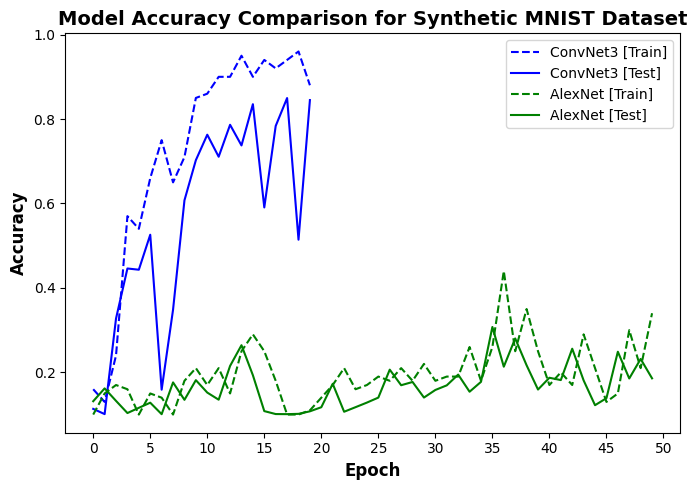

In [57]:
plt.figure(figsize=(7, 5))  # Set figure size

# Plotting with different line styles for train (dashed) and test (solid) data
plt.plot(ConvNet3Syn_train_acc, label="ConvNet3 [Train]", linestyle='--', color='b')  # Dashed line for training
plt.plot(ConvNet3Syn_test_acc, label="ConvNet3 [Test]", linestyle='-', color='b')    # Solid line for testing
plt.plot(alex_net_train_acc, label="AlexNet [Train]", linestyle='--', color='g')  # Dashed line for training
plt.plot(alex_net_test_acc, label="AlexNet [Test]", linestyle='-', color='g')    # Solid line for testing
plt.grid(False)
plt.xticks(np.arange(0, n_epochs+1, 5))
plt.xlabel("Epoch", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.title("Model Accuracy Comparison for Synthetic MNIST Dataset", fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.tight_layout()


## MHIST

In [25]:
torch.cuda.empty_cache()

In [ ]:
(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MHIST_dataset,
    test_MHIST_dataset,
    test_MHIST_dataloader,
    train_MHIST_dataloader,
) = get_dataset("MHIST", "../datasets")

indices = [100, 1800]

# plot 2 images from the dataset
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, ax in enumerate(axes.flat):
    image, label = train_MHIST_dataset[indices[i]]
    # Transpose the image from [3, 224, 224] to [224, 224, 3] for plotting
    image = image.permute(1, 2, 0)
    ax.imshow(image)
    if label == 0:
        ax.set_title("HP")
    else:
        ax.set_title("SSA")
    ax.axis("off")
plt.tight_layout()
plt.savefig(figures_dir + "MHIST_dataset.png", dpi=300)

### ConvNet7

In [ ]:
ConvNet7 = get_network('ConvNetD7', channel, num_classes, im_size)
print(ConvNet7)

In [ ]:
n_epochs = 20
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet7.parameters(), lr=lr)
train_acc, test_acc = [], []
trainLoader = train_MHIST_dataloader
testLoader = test_MHIST_dataloader

progress_bar = tqdm(
    total=n_epochs*len(trainLoader) + n_epochs*len(testLoader),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
    unit = 'step',
)
start_time = time.time()
for ep in range (n_epochs):
    train_loss_avg, train_acc_avg = epoch_S(
        'train',
        trainLoader,
        ConvNet7,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
        
    test_loss_avg, test_acc_avg = epoch_S(
        'test',
        testLoader,
        ConvNet7,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)

flops, _ = get_flops(ConvNet7, testLoader, device)
print("FLOPS: {:,}".format(flops))

### Synthetic dataset generation

In [ ]:
output_file = output_dir + 'MHIST_real_res.pt'
sys.argv = [
    'attention_matching',
    '--dataset', 'MHIST',
    '--data_path', '../datasets',
    '--model', 'ConvNetD7',
    '--K', '2',
    '--ipc', '10',
    '--init', 'real',
    '--batch_real', '32',           # Gpu ram limited
    '--batch_train', '32',          # Gpu ram limted
    '--output_file', output_file
]
MNIST_real_res = attention_matching()


In [ ]:
MHIST_real_res = output_dir + 'MHIST_real_res.pt'
results = torch.load(MHIST_real_res)
real_imgs = results[0][0]
real_labels = results[0][1]

# visualize 2 classes of MHIST (1 by 2)
# 0 = HP, 1 = SSA
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, ax in enumerate(axes.flat):
    img = real_imgs[real_labels == i][0].permute(1, 2, 0).squeeze().numpy()
    img = np.clip(img, 0, 1)  # Ensure pixel values are in the range [0, 1]
    ax.imshow(img)
    if i == 0:
        ax.set_title("HP")
    else:
        ax.set_title("SSA")
    ax.axis("off")
plt.suptitle("Synthetic MHIST Dataset [init img]", fontsize=16)
plt.tight_layout()
plt.show()

syn_imgs = results[1][0]
syn_labels = results[1][1]

# visualize 2 classes of MHIST (1 by 2)
# 0 = HP, 1 = SSA
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, ax in enumerate(axes.flat):
    img = syn_imgs[syn_labels == i][0].permute(1, 2, 0).squeeze().numpy()
    img = np.clip(img, 0, 1)  # Ensure pixel values are in the range [0, 1]
    ax.imshow(img)
    if i == 0:
        ax.set_title("HP")
    else:
        ax.set_title("SSA")
    ax.axis("off")
plt.suptitle("Synthetic MHIST Dataset [final img]", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# plot 10 images from 2 classes of MHIST (5 by 2)
# 0 = HP, 1 = SSA
fig, axes = plt.subplots(5, 2, figsize=(6, 15))
for i in range(2):  # For each class
    for j in range(5):  # For 5 images per class
        img = syn_imgs[syn_labels == i][j].permute(1, 2, 0).squeeze().numpy()
        img = np.clip(img, 0, 1)
        axes[j, i].imshow(img)
        axes[j, i].axis("off")
        if j == 0:
            axes[j, i].set_title("HP" if i == 0 else "SSA")
    
plt.suptitle("Synthetic MHIST Dataset (with Real Dataset)", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
output_file = output_dir + 'MHIST_noise_res.pt'
sys.argv = [
    'attention_matching',
    '--dataset', 'MHIST',
    '--data_path', '../datasets',
    '--model', 'ConvNetD7',
    '--K', '2',
    '--ipc', '10',
    '--init', 'noise',
    '--batch_real', '32',           # Gpu ram limited
    '--batch_train', '32',          # Gpu ram limted
    '--output_file', output_file
]
MHIST_noise_res = attention_matching()


In [ ]:
MHIST_noise_res = output_dir + 'MHIST_noise_res.pt'
results = torch.load(MHIST_noise_res)
real_imgs = results[0][0]
real_labels = results[0][1]

# visualize 2 classes of MHIST (1 by 2)
# 0 = HP, 1 = SSA
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, ax in enumerate(axes.flat):
    img = real_imgs[real_labels == i][0].permute(1, 2, 0).squeeze().numpy()
    img = np.clip(img, 0, 1)  # Ensure pixel values are in the range [0, 1]
    ax.imshow(img)
    if i == 0:
        ax.set_title("HP")
    else:
        ax.set_title("SSA")
    ax.axis("off")
plt.suptitle("Syhthentic MHIST Dataset [init gaussian noise]", fontsize=16)
plt.tight_layout()
plt.show()

syn_imgs = results[1][0]
syn_labels = results[1][1]

# visualize 2 classes of MHIST (1 by 2)
# 0 = HP, 1 = SSA
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, ax in enumerate(axes.flat):
    img = syn_imgs[syn_labels == i][0].permute(1, 2, 0).squeeze().numpy()
    img = np.clip(img, 0, 1)  # Ensure pixel values are in the range [0, 1]
    ax.imshow(img)
    if i == 0:
        ax.set_title("HP")
    else:
        ax.set_title("SSA")
    ax.axis("off")
plt.suptitle("Synthetic MHIST Dataset [final img]", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# plot 10 images from 2 classes of MHIST (5 by 2)
# 0 = HP, 1 = SSA
fig, axes = plt.subplots(5, 2, figsize=(6, 15))
for i in range(2):  # For each class
    for j in range(5):  # For 5 images per class
        img = syn_imgs[syn_labels == i][j].permute(1, 2, 0).squeeze().numpy()
        img = np.clip(img, 0, 1)
        axes[j, i].imshow(img)
        axes[j, i].axis("off")
        if j == 0:
            axes[j, i].set_title("HP" if i == 0 else "SSA")

plt.suptitle("Synthetic MHIST Dataset (with Random Noise)", fontsize=16)
plt.tight_layout()
plt.show()

### ConvNet7 with Synthetic dataset

In [ ]:
syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset('MHIST_real_res.pt')
ConvNet7Syn = get_network('ConvNetD7', channel, num_classes, im_size)
n_epochs = 20
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet7Syn.parameters(), lr=lr)
train_acc, test_acc = [], []
trainLoader = dataloader
testLoader = test_MHIST_dataloader

progress_bar = tqdm(
    total=n_epochs*len(trainLoader) + n_epochs*len(testLoader),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
    unit = 'step',
)
start_time = time.time()
for ep in range (n_epochs):
    train_loss_avg, train_acc_avg = epoch_S(
        'train',
        trainLoader,
        ConvNet7Syn,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
        
    test_loss_avg, test_acc_avg = epoch_S(
        'test',
        testLoader,
        ConvNet7Syn,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)

ConvNet7Syn_train_acc = train_acc
ConvNet7Syn_test_acc = test_acc

flops, _ = get_flops(ConvNet7Syn, testLoader, device)
print("FLOPS: {:,}".format(flops))

In [ ]:
plt.figure(figsize=(7, 5))  # Set figure size

# Plotting with different line styles for train (dashed) and test (solid) data
plt.plot(ConvNet7_train_acc, label="Original Dataset [Train]", linestyle='--', color='b')  # Dashed line for training
plt.plot(ConvNet7_test_acc, label="Original Dataset [Test]", linestyle='-', color='b')    # Solid line for testing
plt.plot(ConvNet7Syn_train_acc, label="Synthetic Dataset [Train]", linestyle='--', color='r')  # Dashed line for training
plt.plot(ConvNet7Syn_test_acc, label="Synthetic Dataset [Test]", linestyle='-', color='r')    # Solid line for testing

plt.grid(False)

# Ensure x-axis displays only whole numbers, every 5 epochs
plt.xticks(np.arange(0, n_epochs+1, 5))

plt.xlabel("Epoch", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.title("ConvNet7 Model Accuracy for MHIST Dataset", fontsize=14, fontweight='bold')

# Add legend with a better location
plt.legend(loc='best', fontsize=10)

# Add a tight layout to minimize unnecessary whitespace
plt.tight_layout()

# Show the plot
plt.show()

### Cross-architecture Generalization

In [ ]:
(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MHIST_dataset,
    test_MHIST_dataset,
    test_MHIST_dataloader,
    train_MHIST_dataloader,
) = get_dataset("MHIST", "../datasets")

alex_net = get_network('AlexNet', channel, num_classes, im_size)
print(alex_net)

In [ ]:
syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset('MHIST_real_res.pt')
n_epochs = 50
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(alex_net.parameters(), lr=lr)
train_acc, test_acc = [], []
trainLoader = dataloader
testLoader = test_MHIST_dataloader

progress_bar = tqdm(
    total=n_epochs*len(trainLoader) + n_epochs*len(testLoader),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
    unit = 'step',
)
start_time = time.time()
for ep in range (n_epochs):
    train_loss_avg, train_acc_avg = epoch_S(
        'train',
        trainLoader,
        alex_net,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )

    test_loss_avg, test_acc_avg = epoch_S(
        'test',
        testLoader,
        alex_net,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )

    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)

alex_net_train_acc = train_acc
alex_net_test_acc = test_acc

flops, _ = get_flops(alex_net, testLoader, device)
print("FLOPS: {:,}".format(flops))

In [ ]:
plt.figure(figsize=(7, 5))  # Set figure size

# Plotting with different line styles for train (dashed) and test (solid) data
plt.plot(ConvNet7Syn_train_acc, label="ConvNet7 [Train]", linestyle='--', color='b')  # Dashed line for training
plt.plot(ConvNet7Syn_test_acc, label="ConvNet7 [Test]", linestyle='-', color='b')    # Solid line for testing
plt.plot(alex_net_train_acc, label="AlexNet [Train]", linestyle='--', color='g')  # Dashed line for training
plt.plot(alex_net_test_acc, label="AlexNet [Test]", linestyle='-', color='g')    # Solid line for testing
plt.grid(False)
plt.xticks(np.arange(0, n_epochs+1, 5))
plt.xlabel("Epoch", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.title("Model Accuracy Comparison for Synthetic MHIST Dataset", fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
